In [49]:
import random
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns


In [50]:
env = gym.make('Taxi-v3')

env.reset()

#Current state
print(env.s)

osbervation_space = env.observation_space

print ("Number of states:", osbervation_space.n)

#primitive actions
action = ["south", "north", "east", "west","pick","drop"]

#Example of a transition
rnd_action = random.randint(0,3)
print('Action Taken:',action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state = env.reset()

print ("Decoded state:", list(env.decode(state)))



106
Number of states: 500
Action Taken: north
Transition probability: {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)}
Next state: 6
Reward recieved: -1
Terminal state: False
Decoded state: [0, 3, 3, 2]


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [51]:
#epsilon-greedy action 

def eps_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    return np.argmax(q_values[state])
  return random.randint(0,q_values.shape[-1]-1)  
  

In [52]:
n_options = 4 
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
def Option(env,state,Q,option,eps=0.1,goal = goal):
  optdone = False
  x,y,passenger,drop=env.decode(state)
  
  if x==goal[option][0] and y==goal[option][1]:
      optdone = True 

      if passenger == option:
        optact = 4
      elif drop == option:
        optact = 5 
      else:   
        optact = 1 if (option in [0,1]) else 0
  else:
    optact = eps_policy(Q[option], 5*x+y, epsilon=eps) 
    
  return [optact,optdone]


In [53]:
#SMDP Q-Learning

rewards1 = []


gamma = 0.9
alpha = 0.08


q_values_SMDP = np.zeros((20,4)) #((n_passenger_positions(=5) x n_drop_locations(= 4)) x n_options)

Q_options = {i:np.zeros((25,4)) for i in range(n_options)} #(n_grid_positions(=25) x n_primitive_actions(= 4))
eps = {i:0.01 for i in range(n_options)}
eps_min = 0.01
eps_decay = 0.99
eps_options = 0.5
count = 0
episodes = 1500

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        x,y,passenger,drop = env.decode(state)
        subState = 4*passenger+drop
        option = eps_policy(q_values_SMDP,subState,epsilon=eps_options)
        eps_options = max(eps_min,eps_decay*eps_options)
        reward_bar = 0
        optdone = False
        tau = 0
        prev = state

        x,y,passenger,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
            [optact,optdone] = Option(env,state,Q_options,option,eps[option])

            [x,y,_,_] = list(env.decode(state))

            next_state,reward,done,_ = env.step(optact)
            
            [x1,y1,_,_] = list(env.decode(next_state))

            reward_bar = gamma*reward_bar + reward

            tau += 1

            total_reward += reward

            eps[option] = max(eps_min,eps_decay*eps[option])

            reward_surr = reward
            if optdone:
                reward_surr=20
            if optact<4:
                Q_options[option][5*x+y, optact] += alpha*(reward_surr + gamma*np.max(Q_options[option][5*x1+y1, :]) - Q_options[option][5*x+y, optact])
            state = next_state
        
        _,_,passenger,drop = env.decode(state)
        subState = 4*passenger+drop

        _,_,passenger,drop = env.decode(prev)
        subPrev = 4*passenger+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**tau)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        
    rewards1.append(total_reward)

    _,_,passenger,drop = env.decode(state)

    if passenger==drop:
      count+=1
      clear_output(wait=True)
      print('Successful Episodes =  ({}/{}), Accuracy = {}%'.format(count,episode+1,100*count/(episode+1)))




Successful Episodes =  (1479/1500), Accuracy = 98.6%


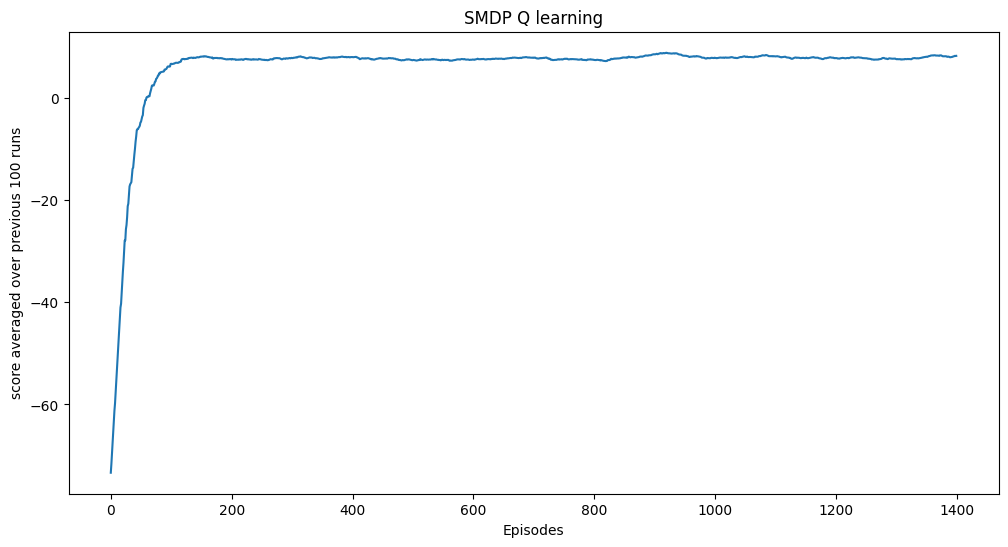

In [54]:
plt.figure(figsize=(12,6))
avg_rewards1 = [np.mean(rewards1[i:i+100]) for i in range(len(rewards1)-100)]
plt.plot(avg_rewards1)
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP Q learning')
plt.show()

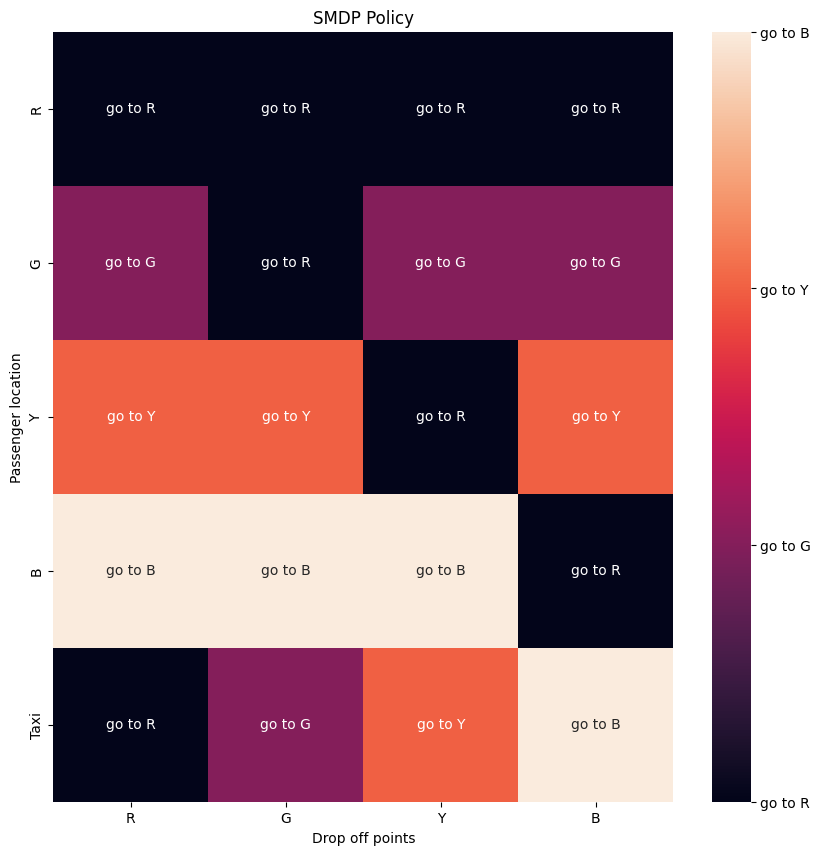

In [55]:
q_values_SMDP_max = np.argmax(q_values_SMDP,axis=1).reshape(5,4)

labels = {0:'go to R',1:'go to G', 2:'go to Y', 3:'go to B'}

annot_text = np.vectorize(labels.get)(q_values_SMDP_max)

figure, axis = plt.subplots(1,1,figsize=(10,10))

ax = sns.heatmap(q_values_SMDP_max,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt='')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['go to R','go to G', 'go to Y', 'go to B'])


axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('SMDP Policy')

plt.show()


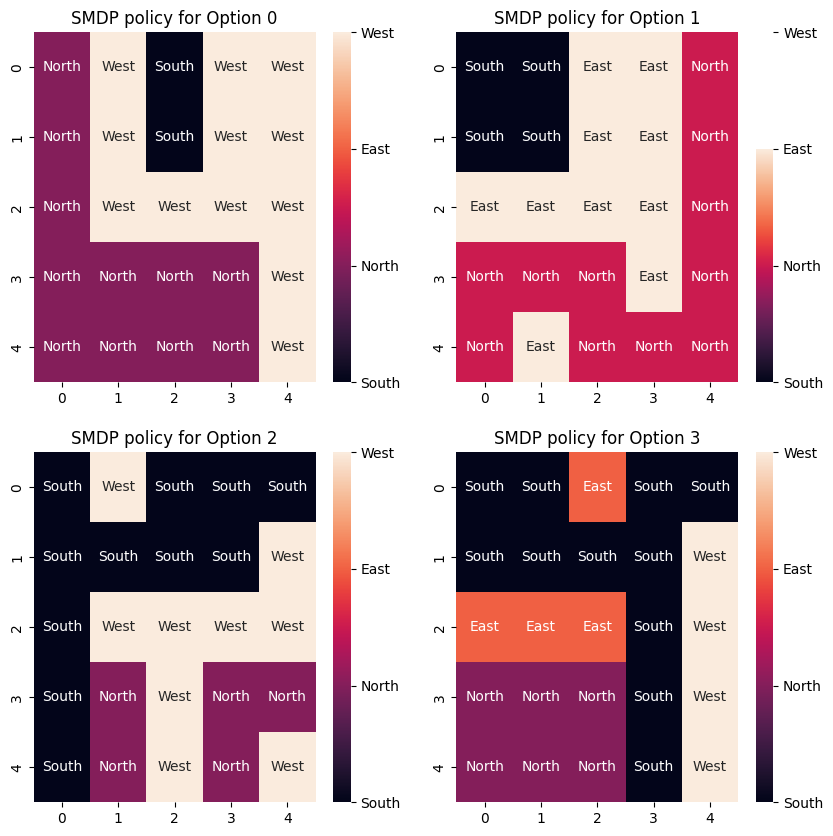

In [56]:
figure, axis = plt.subplots(2,2,figsize=(10,10))

for i in range(2):
    for j in range(2):
        labels = {0:'South',1:'North', 2:'East', 3:'West'}
        annot_text = np.vectorize(labels.get)(np.argmax(Q_options[2*i+j],axis=1).reshape(5,5))
        ax = sns.heatmap(np.argmax(Q_options[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
        axis[i,j].set_title("SMDP policy for Option {}".format(i*2+j))
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i for i in range(4)])
        c_bar.set_ticklabels(['South','North','East','West'])

In [57]:
#Intra Option Q Learning

rewards2 = []

q_values_IOQL = np.zeros((20,4))
Q_options = {i:np.zeros((25,4)) for i in range(n_options)}

eps = {i:0.01 for i in range(n_options)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
episodes = 1500

for episode in range(episodes):
  state = env.reset()    
  done = False
  total_reward = 0

  while not done:
    _,_,passenger,drop = env.decode(state) 
    subState = 4*passenger+drop      
    option = eps_policy(q_values_IOQL, subState, epsilon=eps_main)

    eps_main = max(eps_min,eps_main*eps_decay)

    optdone = False

    while not optdone and not done:
      optact,optdone = Option(env,state,Q_options,option,eps[option])

      next_state, reward, done,_ = env.step(optact)

      total_reward += reward

      [x,y,_,_]=  list(env.decode(state)) 
      [x_next,y_next,_,_] = list(env.decode(next_state)) 

      eps[option] = max(eps_min,eps_decay*eps[option])
      total_reward += reward
      reward_surr = reward

      if optdone:
        reward_surr = 20
      
      if optact<4:
        Q_options[option][5*x+y, optact] += alpha*(reward_surr + gamma*np.max(Q_options[option][5*x_next+y_next, :]) - Q_options[option][5*x+y, optact])

      for op in range(n_options):
        optact_op, optdone_op = Option(env,state,Q_options,op,eps[op])
        if optact_op == optact:
          eps[op] = max(eps_min,eps_decay*eps[op])
          _,_,passenger,drop = env.decode(state)
          _,_,passenger_next, drop_next = env.decode(next_state)
          subState = 4*passenger+drop
          nextsubState = 4*passenger_next+drop_next
          if optdone_op:
            q_values_IOQL[subState,op] += alpha*(reward + gamma*np.max(q_values_IOQL[nextsubState, :]) - q_values_IOQL[subState, op])
          else:
            q_values_IOQL[subState,op] += alpha*(reward + gamma*q_values_IOQL[nextsubState,op] - q_values_IOQL[subState,op])
      
      state = next_state

  rewards2.append(total_reward)
  _,_,passenger,drop = env.decode(state)

  if passenger == drop:
    count += 1
    clear_output(wait=True)
    print('Successful Episodes ({}/{}), Accuracy = {}%'.format(count,episode+1,100*count/(episode+1)))


Successful Episodes (1472/1500), Accuracy = 98.13333333333334%


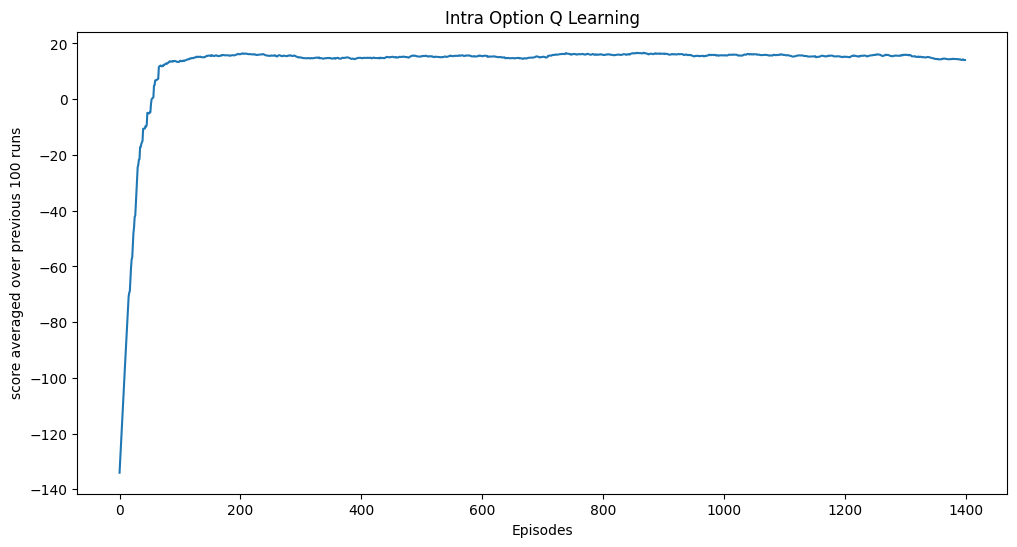

In [58]:
plt.figure(figsize=(12,6))
avg_rewards2 = [np.mean(rewards2[i:i+100]) for i in range(len(rewards2)-100)]
plt.plot(avg_rewards2)
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Intra Option Q Learning')
plt.show()

Text(0.5, 1.0, 'Intra Option Q learning Policy')

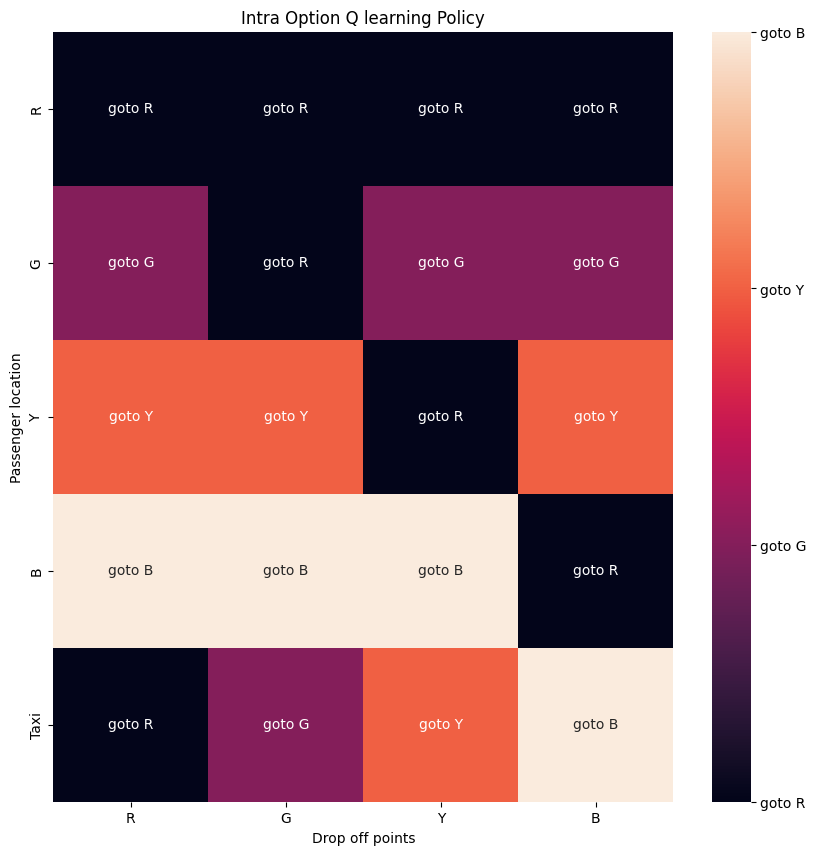

In [59]:
q_values_IOQL_max = np.argmax(q_values_IOQL,axis=1).reshape(5,4)

labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}

annot_text = np.vectorize(labels.get)(q_values_IOQL_max)

figure, axis = plt.subplots(1,1,figsize=(10,10))

ax = sns.heatmap(q_values_IOQL_max,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt='')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])


axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Intra Option Q learning Policy')

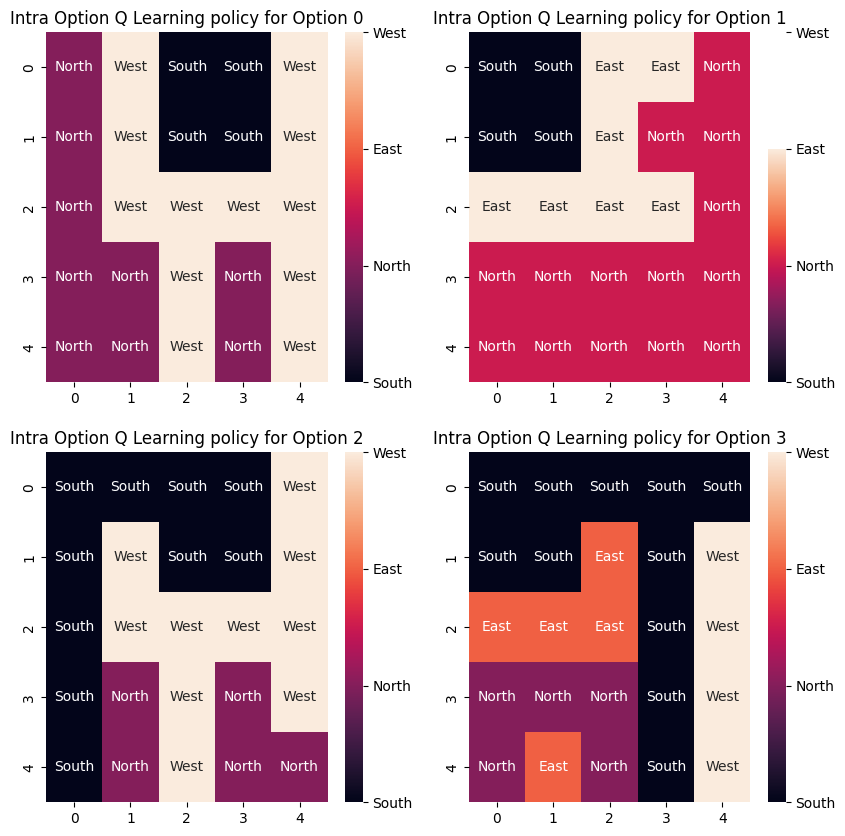

In [60]:
figure, axis = plt.subplots(2,2,figsize=(10,10))

for i in range(2):
    for j in range(2):
        labels = {0:'South',1:'North', 2:'East', 3:'West'}
        annot_text = np.vectorize(labels.get)(np.argmax(Q_options[2*i+j],axis=1).reshape(5,5))
        ax = sns.heatmap(np.argmax(Q_options[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
        axis[i,j].set_title("Intra Option Q Learning policy for Option {}".format(i*2+j))
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i for i in range(4)])
        c_bar.set_ticklabels(['South','North','East','West'])

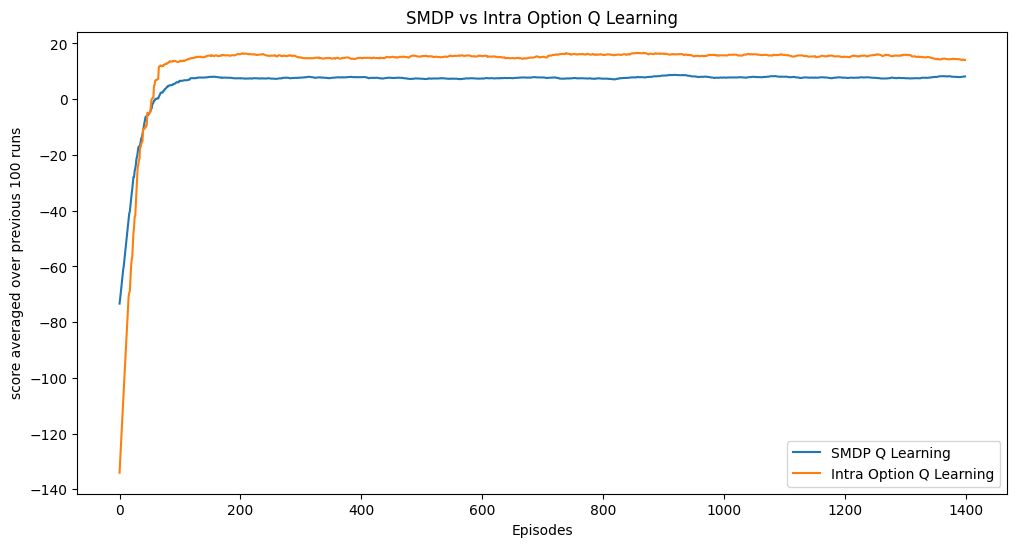

In [61]:
plt.figure(figsize=(12,6))
plt.plot(avg_rewards1,label='SMDP Q Learning')
plt.plot(avg_rewards2,label='Intra Option Q Learning')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP vs Intra Option Q Learning')
plt.legend()
plt.show()